# 1. Imports

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

print("Import completed.")

Import completed.


# 2. Load Data

In [7]:
# Set the path to the dataset
file_path = "../datasets/WELFake_Dataset.csv"

df = pd.read_csv(file_path)
df = df.dropna(subset=["title", "text", "label"])
df["title"] = df["title"].astype(str)
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

sample_frac = 1
# sample_frac = 0.5 # Faster training
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Train-test split
split_idx = int(0.8 * len(df))
train_data = df[:split_idx]
test_data = df[split_idx:]

# 3. Build and Train SVM

In [8]:
# Build the model
model = make_pipeline(TfidfVectorizer(), LinearSVC(random_state=42))

# Train the model
model.fit(train_data['title'], train_data['label'])

# Predict test data
predicted_categories = model.predict(test_data['title'])

# 4. Compute and Display Metrics

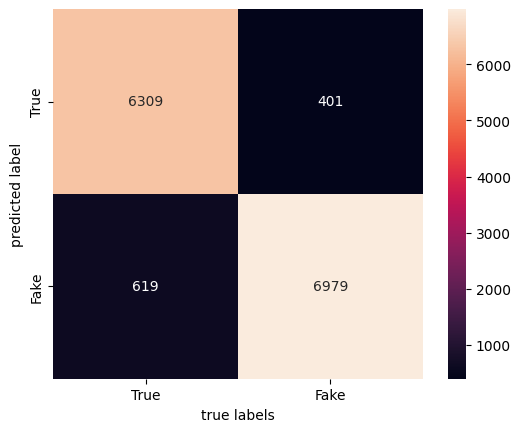

Accuracy: 0.9287112105116019
              precision    recall  f1-score   support

        True       0.94      0.91      0.93      6928
        Fake       0.92      0.95      0.93      7380

    accuracy                           0.93     14308
   macro avg       0.93      0.93      0.93     14308
weighted avg       0.93      0.93      0.93     14308



In [11]:
matrix = confusion_matrix(test_data['label'], predicted_categories)

labels = sorted(df['label'].unique())

sns.heatmap(matrix.T,
            square = True,
            annot=True,
            fmt = "d",
            xticklabels = ["True", "Fake"],
            yticklabels = ["True", "Fake"])

plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

print("Accuracy: {}".format(accuracy_score(test_data['label'], predicted_categories)))

print(classification_report(test_data['label'], predicted_categories, target_names=["True", "Fake"]))

# 5. Hyperparameter Tuning

In [10]:
from sklearn.model_selection import GridSearchCV

# Define the pipeline
pipeline = make_pipeline(
    TfidfVectorizer(),
    LinearSVC(random_state=42)
)

# Define hyperparameter grid
param_grid = {
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2)],
    'tfidfvectorizer__stop_words': [None, 'english'],
    'tfidfvectorizer__max_df': [0.75, 0.9, 1.0],
    'tfidfvectorizer__min_df': [1, 2],
    'linearsvc__C': [0.01, 0.1, 1, 10]  # Regularization parameter
}

# Set up the grid search
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit on training data
grid_search.fit(train_data['title'], train_data['label'])

# Best results
print("Best cross-validation accuracy: {:.4f}".format(grid_search.best_score_))
print("Best parameters:", grid_search.best_params_)

# Use best model to predict on test data
best_model = grid_search.best_estimator_
predicted_categories = best_model.predict(test_data['title'])

# Evaluate
print("Test Accuracy: {:.4f}".format(accuracy_score(test_data['label'], predicted_categories)))

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best cross-validation accuracy: 0.9234
Best parameters: {'linearsvc__C': 1, 'tfidfvectorizer__max_df': 0.75, 'tfidfvectorizer__min_df': 1, 'tfidfvectorizer__ngram_range': (1, 2), 'tfidfvectorizer__stop_words': None}
Test Accuracy: 0.9287
